# Imports

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

# Enabling the gpu to speed up training process

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Setup

basic knowledge gained from https://www.tensorflow.org/tutorials/images/transfer_learning

and https://www.youtube.com/channel/UCHXa4OpASJEwrHrLeIzw7Yg

In [4]:
#type the path to the FinalImageFolder of the MultiClassTestingFolder into here
PATH = 'C:/Users/User/OneDrive/Desktop/BachelorThesisImages/Images/MultiClassTestingFolder/FinalImageFolder'

train_directory = os.path.join(PATH, 'train')
validation_directory = os.path.join(PATH, 'validation')
test_directory = os.path.join(PATH, 'test')

In [5]:
# batchsize is the number of training examples utilized in one iteration
BATCH_SIZE = 32

# imgsize is the size of an image
# this is needed, because the images have to be of the same size
IMG_SIZE_WIDTH = 256
IMG_SIZE_HEIGHT = 256
IMG_SIZE = (IMG_SIZE_WIDTH, IMG_SIZE_HEIGHT)
num_classes = 5

In [6]:
#setting up the train and the validation dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_directory,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_directory,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_directory,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 7000 files belonging to 5 classes.
Found 3000 files belonging to 5 classes.
Found 50 files belonging to 5 classes.


# Preprocessing

In [7]:
# the lower the values, the faster it will work
# thus we want to scale the images from a range of 0-255 to 0-1

train_dataset = train_dataset.map(lambda x,y: (x/255, y))
validation_dataset = validation_dataset.map(lambda x,y: (x/255, y))
test_dataset = test_dataset.map(lambda x,y: (x/255, y))

In [8]:
data_iterator = train_dataset.as_numpy_iterator()

In [9]:
batch = data_iterator.next()

In [10]:
def indexToClassName(index):
    if index == 0:
        return "Base Gesture"
    elif index == 1:
        return "Fist Gesture"
    elif index == 2:
        return "Ok Gesture"
    elif index == 3:
        return "Peace Gesture"
    elif index == 4:
        return "Rock On Gesture"

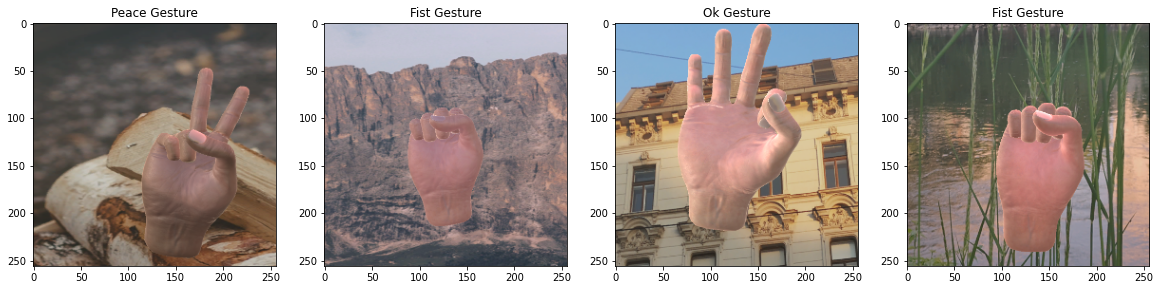

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(indexToClassName(batch[1][idx]))

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Build Neural Network Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation, RandomZoom, Rescaling, Activation

In [14]:
model = Sequential([
  RandomRotation(0.1, input_shape=(IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, 3)),
  RandomZoom(0.1),
  Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, 3)),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.5),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

In [15]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0

# Training the Neural Network

In [17]:
logdir='logs'

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [19]:
hist = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=[tensorboard_callback, earlystopping_callback])

Epoch 1/100
219/219 [==============================] - 91s 250ms/step - loss: 1.5756 - accuracy: 0.2987 - val_loss: 1.3348 - val_accuracy: 0.4597
Epoch 2/100
219/219 [==============================] - 21s 97ms/step - loss: 1.2991 - accuracy: 0.4636 - val_loss: 0.9786 - val_accuracy: 0.6383
Epoch 3/100
219/219 [==============================] - 14s 63ms/step - loss: 1.0424 - accuracy: 0.5950 - val_loss: 0.6634 - val_accuracy: 0.7657
Epoch 4/100
219/219 [==============================] - 14s 65ms/step - loss: 0.7448 - accuracy: 0.7216 - val_loss: 0.4762 - val_accuracy: 0.8517
Epoch 5/100
219/219 [==============================] - 15s 67ms/step - loss: 0.5055 - accuracy: 0.8217 - val_loss: 0.2912 - val_accuracy: 0.9097
Epoch 6/100
219/219 [==============================] - 14s 64ms/step - loss: 0.3679 - accuracy: 0.8729 - val_loss: 0.1970 - val_accuracy: 0.9337
Epoch 7/100
219/219 [==============================] - 15s 67ms/step - loss: 0.2801 - accuracy: 0.9019 - val_loss: 0.1570 - val_a

# Performance Graphs

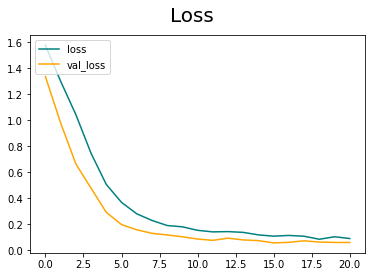

In [20]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

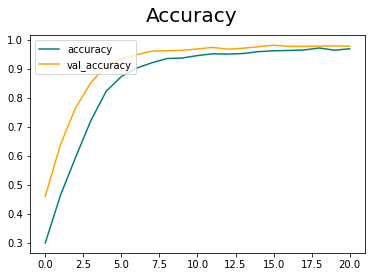

In [21]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Testing a single image

In [22]:
import cv2 as opencv

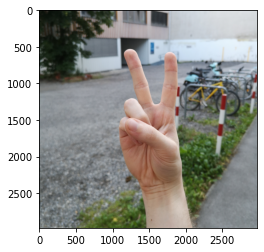

In [23]:
img = opencv.imread('C:/Users/User/OneDrive/Desktop/BachelorThesisImages/Images/MultiClassTestingFolder/FinalImageFolder/test/PeaceGesture/IMG_20220612_060548.jpg')
img = opencv.cvtColor(img, opencv.COLOR_BGR2RGB)
plt.imshow(img/255)
plt.show()

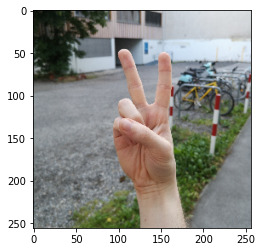

In [24]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [25]:
yhat = model.predict(np.expand_dims(resize, 0))

In [26]:
yhat

array([[-200.57326, -145.20457,  222.71606,  689.55115, -183.71432]],
      dtype=float32)

In [27]:
maxValueClass = 0
maxValue = float('-inf')
for i in range(len(yhat[0])):
    if(yhat[0][i] > maxValue):
        maxValue = yhat[0][i]
        maxValueClass = i
        
print("predicted class is " + indexToClassName(maxValueClass) + " with a value of " + str(maxValue))

predicted class is Peace Gesture with a value of 689.55115


# Testing whole folder

image number 0


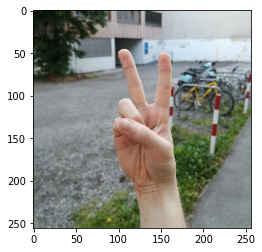

[[-0.31420314 -7.857007    7.1486454  13.0403385  -4.7971783 ]]
predicted class is Peace Gesture with a value of 13.0403385
Correct: predicted as Peace Gesture and is Peace Gesture
______________
image number 1


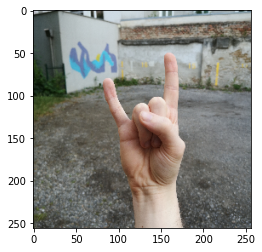

[[-3.1025522  -2.7140558  -2.9679341   0.21858062  6.9645343 ]]
predicted class is Rock On Gesture with a value of 6.9645343
Correct: predicted as Rock On Gesture and is Rock On Gesture
______________
image number 2


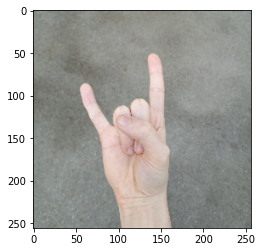

[[-3.010441   2.9053485 -1.7336338  1.1768494  1.835607 ]]
predicted class is Fist Gesture with a value of 2.9053485
False: predicted as Fist Gesture but is Rock On Gesture
______________
image number 3


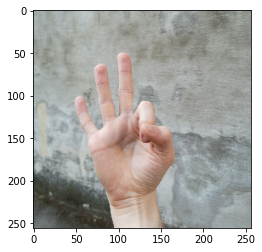

[[-4.055102  -4.5322657  6.6104684  5.8023753 -2.0380805]]
predicted class is Ok Gesture with a value of 6.6104684
Correct: predicted as Ok Gesture and is Ok Gesture
______________
image number 4


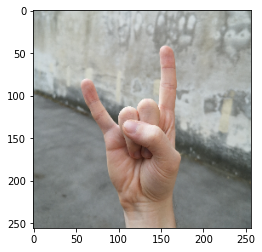

[[-2.6831732 -5.8866563 -2.9922066  3.7043424 11.018884 ]]
predicted class is Rock On Gesture with a value of 11.018884
Correct: predicted as Rock On Gesture and is Rock On Gesture
______________
image number 5


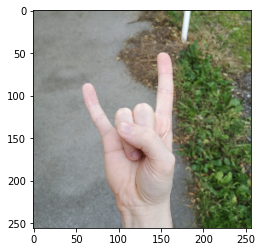

[[-3.6117141   4.3757677  -1.4522241   1.1251612   0.94496316]]
predicted class is Fist Gesture with a value of 4.3757677
False: predicted as Fist Gesture but is Rock On Gesture
______________
image number 6


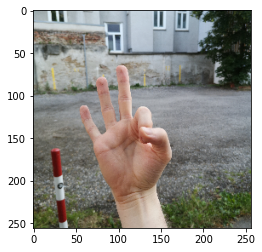

[[-0.0614181 -1.6507559  6.6562405  1.4465435 -2.77015  ]]
predicted class is Ok Gesture with a value of 6.6562405
Correct: predicted as Ok Gesture and is Ok Gesture
______________
image number 7


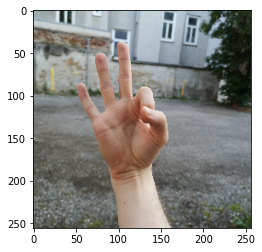

[[ 1.0794625 -5.9515715 11.036919   3.896104  -7.5890355]]
predicted class is Ok Gesture with a value of 11.036919
Correct: predicted as Ok Gesture and is Ok Gesture
______________
image number 8


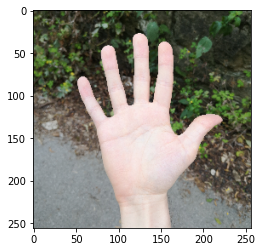

[[ 3.0644467 -4.94203    2.4424996  1.6688948  1.4760028]]
predicted class is Base Gesture with a value of 3.0644467
Correct: predicted as Base Gesture and is Base Gesture
______________
image number 9


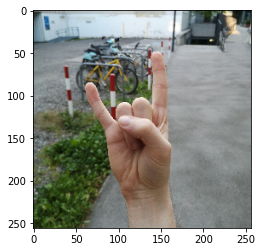

[[-2.3553536 -4.1690335 -5.4040775  1.6998944 12.867009 ]]
predicted class is Rock On Gesture with a value of 12.867009
Correct: predicted as Rock On Gesture and is Rock On Gesture
______________
image number 10


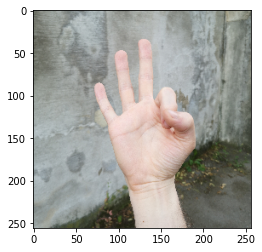

[[-1.7379916  -0.5727271   1.3410561   2.3788884   0.59649926]]
predicted class is Peace Gesture with a value of 2.3788884
False: predicted as Peace Gesture but is Ok Gesture
______________
image number 11


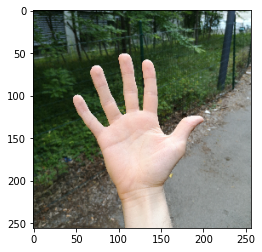

[[17.266546  -7.6063337 10.655723  -3.241205  -1.2240278]]
predicted class is Base Gesture with a value of 17.266546
Correct: predicted as Base Gesture and is Base Gesture
______________
image number 12


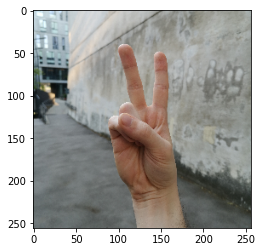

[[-0.26034582 -4.076522    4.987636    7.658124   -2.5296047 ]]
predicted class is Peace Gesture with a value of 7.658124
Correct: predicted as Peace Gesture and is Peace Gesture
______________
image number 13


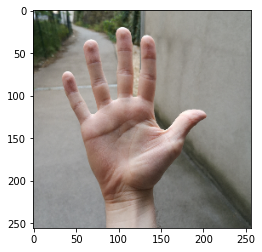

[[ 10.549712  -16.395458    8.360363    1.0369782   2.8613122]]
predicted class is Base Gesture with a value of 10.549712
Correct: predicted as Base Gesture and is Base Gesture
______________
image number 14


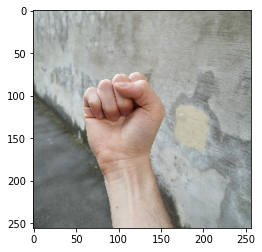

[[-3.8453267   7.945082   -2.3656201   1.1191343   0.48600078]]
predicted class is Fist Gesture with a value of 7.945082
Correct: predicted as Fist Gesture and is Fist Gesture
______________
image number 15


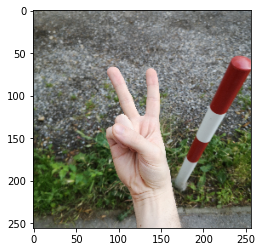

[[-1.8931975  -0.99020773  0.8619349   3.7329504  -0.3161412 ]]
predicted class is Peace Gesture with a value of 3.7329504
Correct: predicted as Peace Gesture and is Peace Gesture
______________
image number 16


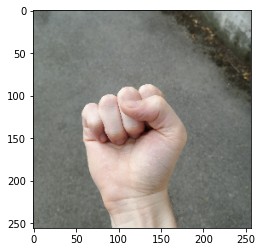

[[-3.3650699   4.763355   -0.89803547 -0.06255164  1.7854191 ]]
predicted class is Fist Gesture with a value of 4.763355
Correct: predicted as Fist Gesture and is Fist Gesture
______________
image number 17


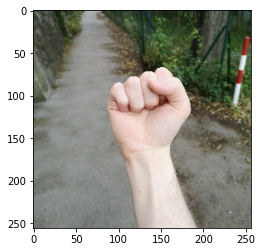

[[-1.5369532   3.7341383  -0.32072636  0.15912344 -0.09923643]]
predicted class is Fist Gesture with a value of 3.7341383
Correct: predicted as Fist Gesture and is Fist Gesture
______________
image number 18


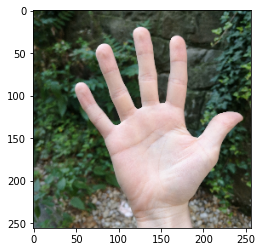

[[11.819013   -8.895352    5.044856   -0.55231065  4.314134  ]]
predicted class is Base Gesture with a value of 11.819013
Correct: predicted as Base Gesture and is Base Gesture
______________
image number 19


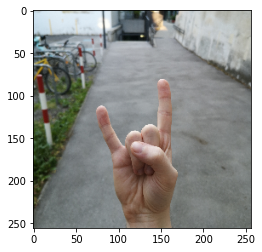

[[-1.3563939  -0.36389518 -1.6057965  -0.08874231  6.4075804 ]]
predicted class is Rock On Gesture with a value of 6.4075804
Correct: predicted as Rock On Gesture and is Rock On Gesture
______________
image number 20


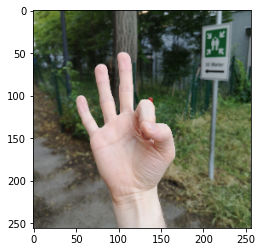

[[-2.1704931   0.6690994   2.1533527   0.8933291   0.46904105]]
predicted class is Ok Gesture with a value of 2.1533527
Correct: predicted as Ok Gesture and is Ok Gesture
______________
image number 21


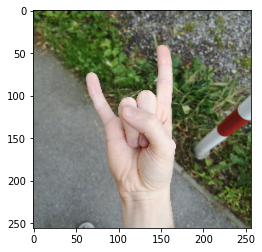

[[-3.371218  -0.4307682 -2.053935   3.5723665  3.367307 ]]
predicted class is Peace Gesture with a value of 3.5723665
False: predicted as Peace Gesture but is Rock On Gesture
______________
image number 22


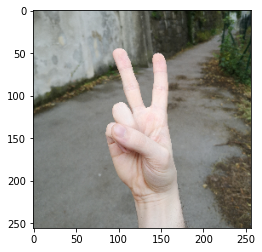

[[-1.9691285   1.3511766  -0.24262993  1.8750217   0.5623906 ]]
predicted class is Peace Gesture with a value of 1.8750217
Correct: predicted as Peace Gesture and is Peace Gesture
______________
image number 23


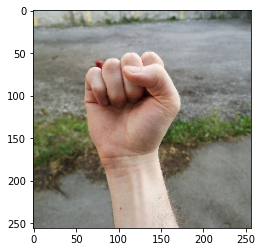

[[-2.4758668   5.07052     1.3508661  -0.2586692  -0.29116297]]
predicted class is Fist Gesture with a value of 5.07052
Correct: predicted as Fist Gesture and is Fist Gesture
______________
image number 24


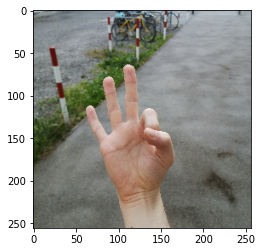

[[ 0.28381324 -3.2260382   6.9742565   4.1012907  -3.2220883 ]]
predicted class is Ok Gesture with a value of 6.9742565
Correct: predicted as Ok Gesture and is Ok Gesture
______________
image number 25


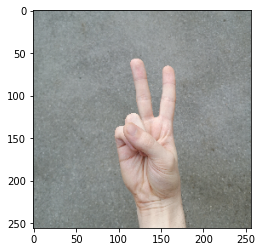

[[-2.4452102  -1.7734095   1.5497912   5.5862346   0.45520765]]
predicted class is Peace Gesture with a value of 5.5862346
Correct: predicted as Peace Gesture and is Peace Gesture
______________
image number 26


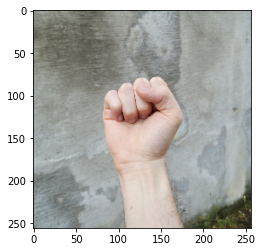

[[-2.2549815   3.934433    0.0738271  -0.0533874  -0.03222993]]
predicted class is Fist Gesture with a value of 3.934433
Correct: predicted as Fist Gesture and is Fist Gesture
______________
image number 27


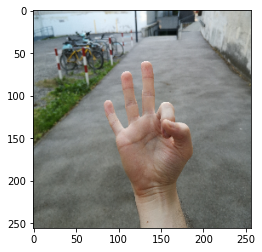

[[-1.9889703 -4.225869   6.3101654  6.1509867 -2.3087356]]
predicted class is Ok Gesture with a value of 6.3101654
Correct: predicted as Ok Gesture and is Ok Gesture
______________
image number 28


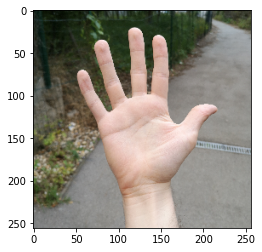

[[ 11.754467  -12.011496    6.549078    1.0406487   2.1716602]]
predicted class is Base Gesture with a value of 11.754467
Correct: predicted as Base Gesture and is Base Gesture
______________
image number 29


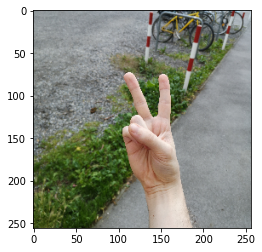

[[ 1.1994889 -3.9193227  5.9641714  8.210583  -5.0836897]]
predicted class is Peace Gesture with a value of 8.210583
Correct: predicted as Peace Gesture and is Peace Gesture
______________
image number 30


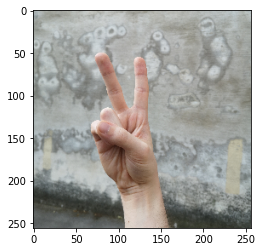

[[ 1.3169187 -5.6704035  4.103304   8.909774  -2.7799075]]
predicted class is Peace Gesture with a value of 8.909774
Correct: predicted as Peace Gesture and is Peace Gesture
______________
image number 31


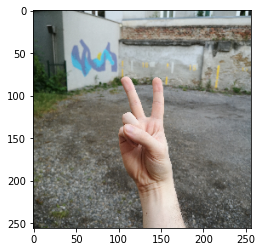

[[ 0.30907762 -0.0899675   1.3200637   2.1177099  -1.7437199 ]]
predicted class is Peace Gesture with a value of 2.1177099
Correct: predicted as Peace Gesture and is Peace Gesture
______________
image number 32


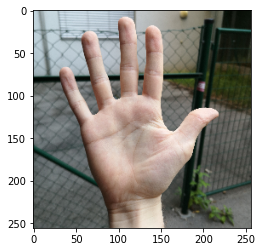

[[ 3.0510604 -7.28838    2.4524245  1.9790812  3.571842 ]]
predicted class is Rock On Gesture with a value of 3.571842
False: predicted as Rock On Gesture but is Base Gesture
______________
image number 33


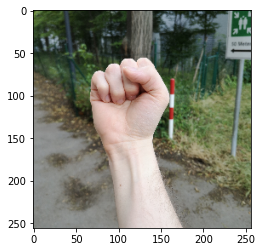

[[-0.9963918   4.355419    0.91596735  0.52996427 -1.0886837 ]]
predicted class is Fist Gesture with a value of 4.355419
Correct: predicted as Fist Gesture and is Fist Gesture
______________
image number 34


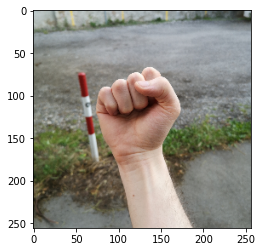

[[-2.614828    8.279791   -0.01620521 -1.2050639  -0.43517995]]
predicted class is Fist Gesture with a value of 8.279791
Correct: predicted as Fist Gesture and is Fist Gesture
______________
image number 35


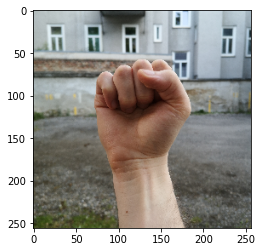

[[-1.6757641   2.9928882   2.2452874  -0.19560693 -1.8365289 ]]
predicted class is Fist Gesture with a value of 2.9928882
Correct: predicted as Fist Gesture and is Fist Gesture
______________
image number 36


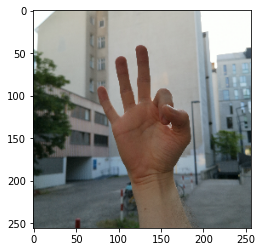

[[ 0.8791927 -3.5376573  3.751729   2.7641726 -2.9833894]]
predicted class is Ok Gesture with a value of 3.751729
Correct: predicted as Ok Gesture and is Ok Gesture
______________
image number 37


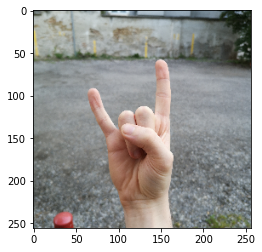

[[-1.5188806 -1.2874812 -2.2290838  0.6476982  5.708304 ]]
predicted class is Rock On Gesture with a value of 5.708304
Correct: predicted as Rock On Gesture and is Rock On Gesture
______________
image number 38


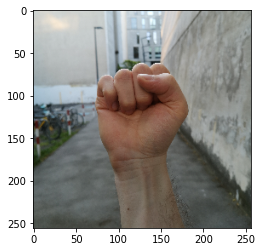

[[-3.748546    5.166408    2.3293905   0.67080146 -1.1402626 ]]
predicted class is Fist Gesture with a value of 5.166408
Correct: predicted as Fist Gesture and is Fist Gesture
______________
image number 39


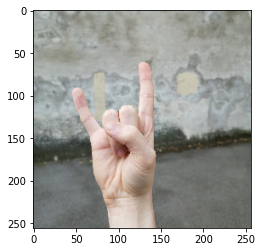

[[-0.5534818 -1.9318358 -0.8735585  1.3778114  6.17837  ]]
predicted class is Rock On Gesture with a value of 6.17837
Correct: predicted as Rock On Gesture and is Rock On Gesture
______________
image number 40


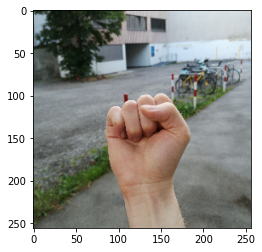

[[-7.4989023   9.670686   -1.6024895   0.84238166  2.0751631 ]]
predicted class is Fist Gesture with a value of 9.670686
Correct: predicted as Fist Gesture and is Fist Gesture
______________
image number 41


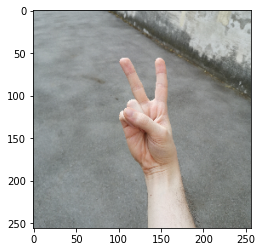

[[-3.289187  -2.963933   3.036764   8.150363  -1.6399926]]
predicted class is Peace Gesture with a value of 8.150363
Correct: predicted as Peace Gesture and is Peace Gesture
______________
image number 42


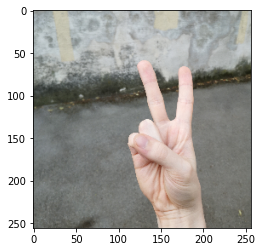

[[-2.749124   2.0458918 -1.0655955  2.2927952  1.2882458]]
predicted class is Peace Gesture with a value of 2.2927952
Correct: predicted as Peace Gesture and is Peace Gesture
______________
image number 43


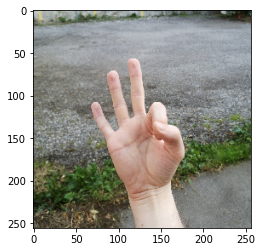

[[-2.8075678 -1.8332512  3.4673214  3.2161517 -0.0560463]]
predicted class is Ok Gesture with a value of 3.4673214
Correct: predicted as Ok Gesture and is Ok Gesture
______________
image number 44


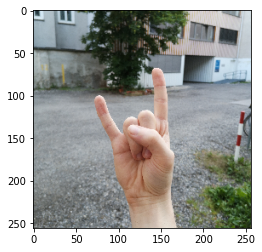

[[-2.9048264 -2.1439078 -4.405457   1.0938038  8.723524 ]]
predicted class is Rock On Gesture with a value of 8.723524
Correct: predicted as Rock On Gesture and is Rock On Gesture
______________
image number 45


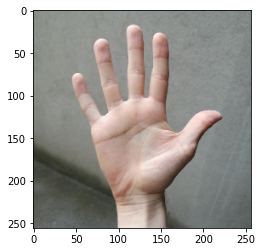

[[ 10.302748   -14.845334     6.467894     0.33331364   5.04348   ]]
predicted class is Base Gesture with a value of 10.302748
Correct: predicted as Base Gesture and is Base Gesture
______________
image number 46


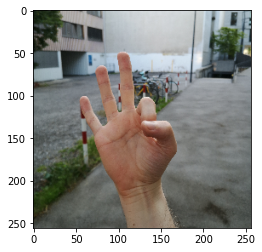

[[ 0.8247654 -5.643677   7.6878133  3.2309802 -2.6871355]]
predicted class is Ok Gesture with a value of 7.6878133
Correct: predicted as Ok Gesture and is Ok Gesture
______________
image number 47


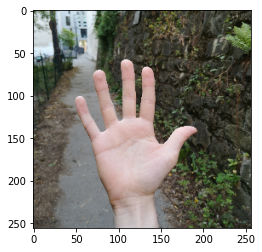

[[ 7.2274857 -0.4864903  5.513801  -2.2609208 -2.6711822]]
predicted class is Base Gesture with a value of 7.2274857
Correct: predicted as Base Gesture and is Base Gesture
______________
image number 48


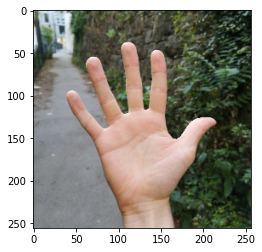

[[18.16429   -9.159856   6.7510724 -4.345459   5.870364 ]]
predicted class is Base Gesture with a value of 18.16429
Correct: predicted as Base Gesture and is Base Gesture
______________
image number 49


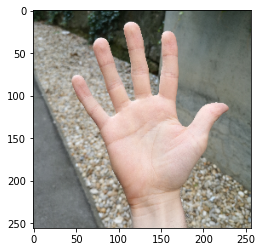

[[ 13.744964  -10.8064375   6.19293    -2.508043    1.3089174]]
predicted class is Base Gesture with a value of 13.744964
Correct: predicted as Base Gesture and is Base Gesture
______________
Amount categorized: 50
Correctly categorized: 45
Falsely categorized: 5
Ratio: 0.9


In [28]:
imageCount = 0
correctCount = 0
falseCount = 0

currBatch = 0;

confusionmatrix = []
for i in range(num_classes):
    confusionmatrix.append([])
    for j in range(num_classes):
        confusionmatrix[i].append(0)

for batch in test_dataset.as_numpy_iterator():
    for idx, img in enumerate(batch[0]):
        print("image number " + str(BATCH_SIZE * currBatch + idx))
        plt.imshow(img)
        plt.show()

        yhat = model.predict(np.expand_dims(img, 0))
        print(yhat)
        
        maxValueClass = 0
        maxValue = float('-inf')
        for i in range(len(yhat[0])):
            if(yhat[0][i] > maxValue):
                maxValue = yhat[0][i]
                maxValueClass = i
                
        print("predicted class is " + indexToClassName(maxValueClass) + " with a value of " + str(maxValue))

        if(maxValueClass == batch[1][idx]):
            # predicted as handMissing but is handExists
            print("Correct: predicted as " + indexToClassName(maxValueClass) + " and is " + indexToClassName(batch[1][idx]))
            correctCount += 1
        else:
            # predicted as handMissing and is handMissing
            print("False: predicted as " + indexToClassName(maxValueClass) + " but is " + indexToClassName(batch[1][idx]))
            falseCount += 1
        
        confusionmatrix[batch[1][idx]][maxValueClass] += 1
            
        imageCount += 1
        print("______________")
    currBatch += 1
    
print("Amount categorized: " + str(imageCount))
print("Correctly categorized: " + str(correctCount))
print("Falsely categorized: " + str(falseCount))
print("Ratio: " + str(correctCount / imageCount))

normalDetectionRatio = correctCount / imageCount

In [29]:
normalDetectionRatio

0.9

In [30]:
confusionmatrix

[[9, 0, 0, 0, 1],
 [0, 10, 0, 0, 0],
 [0, 0, 9, 1, 0],
 [0, 0, 0, 10, 0],
 [0, 2, 0, 1, 7]]

In [31]:
display_labels = []

for i in range(num_classes):
    display_labels.append(indexToClassName(i))

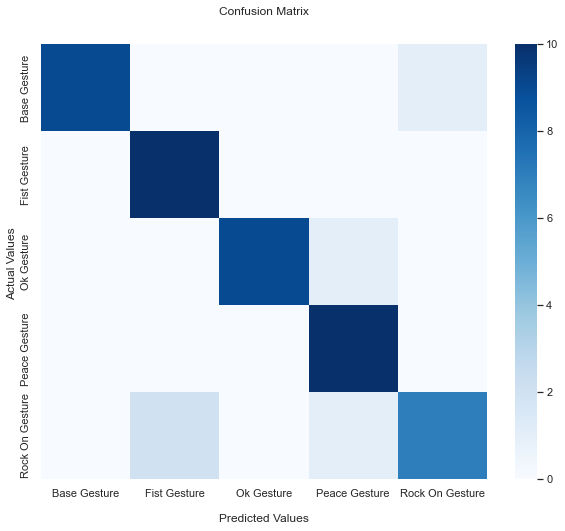

In [32]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(10,8)})

ax = sns.heatmap(confusionmatrix, fmt='', cmap='Blues', vmin = 0, vmax = 10)

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(display_labels)
ax.yaxis.set_ticklabels(display_labels)

## Display the visualization of the Confusion Matrix.
plt.show()